In [1]:
# Import torch
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Setup random seed
RANDOM_SEED = 42

In [2]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

X, y = make_moons(n_samples = 1000, noise=0.1, random_state = 42)

X.shape, y.shape

((1000, 2), (1000,))

In [3]:
# Turn data into a DataFrame
import pandas as pd
df = pd.DataFrame(data=X, columns=['X-axis', 'Y-axis'])
df['Target'] = y
df['Target'].unique(), df.head()

(array([1, 0]),
      X-axis    Y-axis  Target
 0 -0.051470  0.444199       1
 1  1.032017 -0.419741       1
 2  0.867892 -0.254827       1
 3  0.288851 -0.448669       1
 4 -0.833439  0.535057       0)

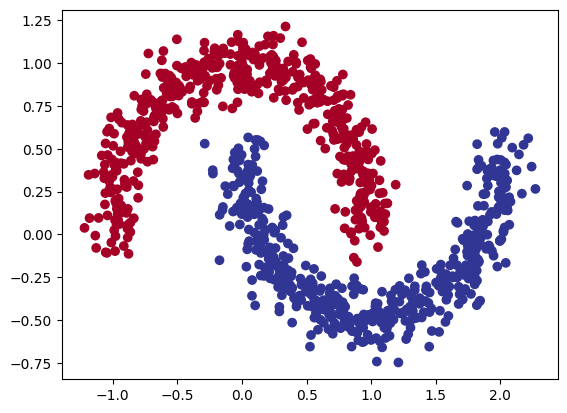

In [4]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [5]:
# Turn data into tensors of dtype float
X = torch.tensor(data = X, dtype = torch.float)
y = torch.tensor(data = y, dtype = torch.float)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

In [6]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    def __init__(self, in_features, out_features, hidden_layers):
      super().__init__()
      self.lap = nn.Sequential(
          nn.Linear(in_features = in_features, out_features = hidden_layers),
          nn.ReLU(),
          nn.Linear(in_features = hidden_layers, out_features = hidden_layers),
          nn.ReLU(),
          nn.Linear(in_features = hidden_layers, out_features = out_features),
      )

    def forward(self, x):
        return self.lap(x)

# Instantiate the model
IN_FEATURES = 2
OUT_FEATURES = 1
HIDDEN_LAYERS = 256

model_0 = MoonModelV0(IN_FEATURES, OUT_FEATURES, HIDDEN_LAYERS).to(device)
model_0

MoonModelV0(
  (lap): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [7]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()
# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of model to optimize
                            lr=0.1) # learning rate

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
  * Do a forward pass of the model to see what's coming out in the form of logits, prediction probabilities and labels.
  * To measure model accuray, you can create your own accuracy function or use the accuracy function in [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/).
  * Train the model for long enough for it to reach over 96% accuracy.
  * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [8]:
# What's coming out of our model?
logits = model_0(X_train.to(device).squeeze())
# logits (raw outputs of model)
print(f"Logits:{logits[:5]}")

pred_probs = torch.sigmoid(logits)

# Prediction probabilities
print(f"Pred probs:{pred_probs[:5]}")

pred_labels = torch.round(pred_probs)

# Prediction labels
print(f"Pred labels:{pred_labels[:5]}")



Logits:tensor([[-0.2514],
        [-0.0653],
        [-0.2844],
        [-0.0661],
        [-0.2150]], grad_fn=<SliceBackward0>)
Pred probs:tensor([[0.4375],
        [0.4837],
        [0.4294],
        [0.4835],
        [0.4465]], grad_fn=<SliceBackward0>)
Pred labels:tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<SliceBackward0>)


In [9]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
!pip -q install torchmetrics # Colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## TODO: Uncomment this code to use the Accuracy function
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 6.2 MB/s eta 0:00:00


MulticlassAccuracy()

In [10]:
## TODO: Uncomment this to set the seed
torch.manual_seed(RANDOM_SEED)

# Setup epochs
epochs = 1000

# Send data to the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through the data
for epoch in range(epochs):
  ### Training
  model_0.train()
  # 1. Forward pass (logits output)
  y_logits = model_0(X_train).squeeze()
  # Turn logits into prediction probabilities
  y_pred_probs = torch.sigmoid(y_logits)
  # Turn prediction probabilities into prediction labels
  y_pred = torch.round(y_pred_probs)

  # 2. Calculaute the loss
  loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs

  # Calculate the accuracy
  acc = acc_fn(y_pred, y_train.int()) # the accuracy function needs to compare pred labels (not logits) with actual labels

  # 3. Zero the gradients
  optimizer.zero_grad()


  # 4. Loss backward (perform backpropagation)
  loss.backward()

  # 5. Step the optimizer (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass (to get the logits)
    y_test_logits = model_0(X_test).squeeze()
    # Turn the test logits into prediction labels
    y_test_pred_probs = torch.sigmoid(y_test_logits)
    y_test_pred = torch.round(y_test_pred_probs)
    # 2. Caculate the test loss/acc
    test_loss = loss_fn(y_test_logits, y_test)
    test_acc = acc_fn(y_test_pred, y_test.int())


  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")


Epoch: 0 | Loss: 0.74 Acc: 0.46 | Test loss: 0.67 Test acc: 0.81
Epoch: 100 | Loss: 0.17 Acc: 0.92 | Test loss: 0.22 Test acc: 0.90
Epoch: 200 | Loss: 0.11 Acc: 0.96 | Test loss: 0.15 Test acc: 0.93
Epoch: 300 | Loss: 0.07 Acc: 0.98 | Test loss: 0.09 Test acc: 0.96
Epoch: 400 | Loss: 0.04 Acc: 1.00 | Test loss: 0.06 Test acc: 0.98
Epoch: 500 | Loss: 0.02 Acc: 1.00 | Test loss: 0.04 Test acc: 0.99
Epoch: 600 | Loss: 0.02 Acc: 1.00 | Test loss: 0.03 Test acc: 0.99
Epoch: 700 | Loss: 0.01 Acc: 1.00 | Test loss: 0.03 Test acc: 0.99
Epoch: 800 | Loss: 0.01 Acc: 1.00 | Test loss: 0.02 Test acc: 0.99
Epoch: 900 | Loss: 0.01 Acc: 1.00 | Test loss: 0.02 Test acc: 0.99


## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [11]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

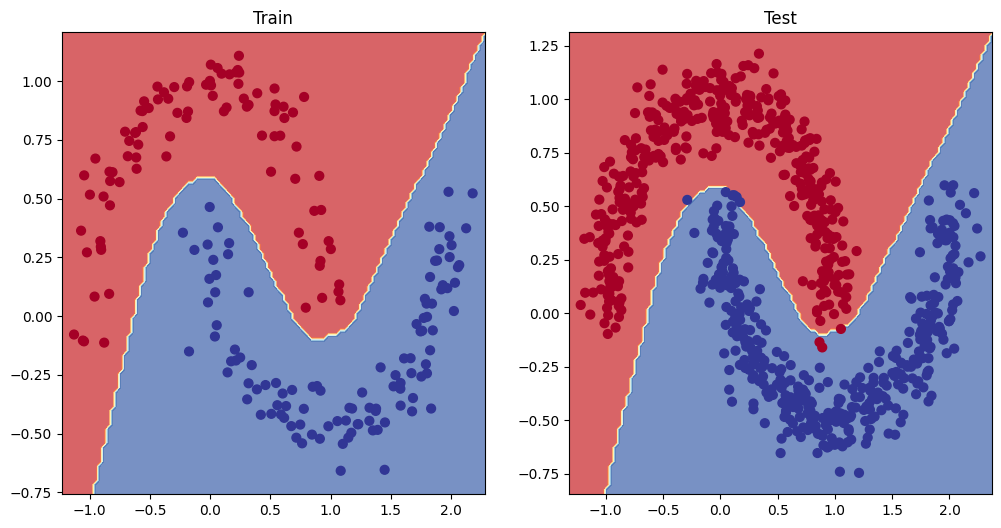

In [12]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

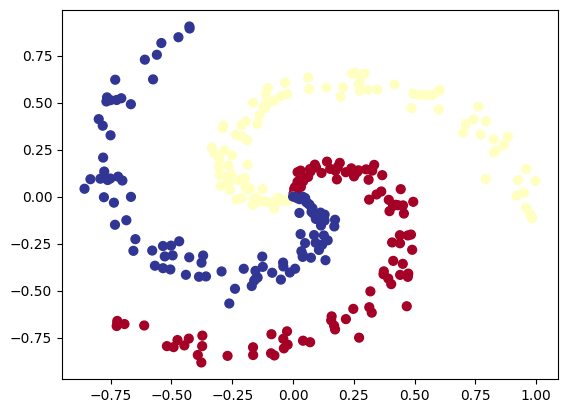

In [167]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [168]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

In [169]:
X.shape, y.unique()

(torch.Size([300, 2]), tensor([0, 1, 2]))

In [170]:
# Let's calculuate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## TODO: uncomment the two lines below to send the accuracy function to the device
acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
acc_fn

MulticlassAccuracy()

In [176]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model by subclassing nn.Module
class ThreePointModel(nn.Module):
  def __init__(self, in_features, out_features, hidden_layers):
    super().__init__()
    self.lap = nn.Sequential(
        nn.Linear(in_features = in_features, out_features = hidden_layers),
        nn.ReLU(),
        nn.Linear(in_features = hidden_layers, out_features = hidden_layers),
        nn.ReLU(),
        nn.Linear(in_features = hidden_layers, out_features = out_features)
    )
  def forward(self, x):
    return self.lap(x)

IN_FEATURES = 2
OUT_FEATURES = 3
HIDDEN_LAYER = 64
model_1 = ThreePointModel(IN_FEATURES, OUT_FEATURES, HIDDEN_LAYER)
model_1


ThreePointModel(
  (lap): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [177]:
# Setup data to be device agnostic
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

# Print out untrained model outputs
print("Logits:")
print(model_1(X_train)[:3])

print("Pred probs:")
print(torch.softmax(model_1(X_train)[:3], dim=1))

print("Pred labels:")
print(torch.softmax(model_1(X_train)[:3], dim=1).argmax(dim=1))

torch.float32 torch.float32 torch.int64 torch.int64
Logits:
tensor([[ 0.0623,  0.1415, -0.0608],
        [ 0.0221,  0.1318, -0.0627],
        [-0.0222,  0.0980, -0.1818]], grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.3371, 0.3649, 0.2981],
        [0.3295, 0.3677, 0.3027],
        [0.3356, 0.3784, 0.2860]], grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([1, 1, 1])


In [178]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),
                             lr=0.02)

In [179]:
# Build a training loop for the model
epochs = 1000

# Loop over data
for epoch in range(epochs):
  ## Training
  model_1.train()
  # 1. forward pass
  y_logits = model_1(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backwards
  loss.backward()

  # 5. optimizer step step step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.11 Acc: 0.30 | Test loss: 1.03 Test acc: 0.55
Epoch: 100 | Loss: 0.00 Acc: 1.00 | Test loss: 0.08 Test acc: 0.95
Epoch: 200 | Loss: 0.00 Acc: 1.00 | Test loss: 0.09 Test acc: 0.96
Epoch: 300 | Loss: 0.00 Acc: 1.00 | Test loss: 0.11 Test acc: 0.97
Epoch: 400 | Loss: 0.00 Acc: 1.00 | Test loss: 0.14 Test acc: 0.96
Epoch: 500 | Loss: 0.00 Acc: 1.00 | Test loss: 0.16 Test acc: 0.96
Epoch: 600 | Loss: 0.00 Acc: 1.00 | Test loss: 0.18 Test acc: 0.96
Epoch: 700 | Loss: 0.00 Acc: 1.00 | Test loss: 0.20 Test acc: 0.96
Epoch: 800 | Loss: 0.00 Acc: 1.00 | Test loss: 0.21 Test acc: 0.96
Epoch: 900 | Loss: 0.00 Acc: 1.00 | Test loss: 0.23 Test acc: 0.96


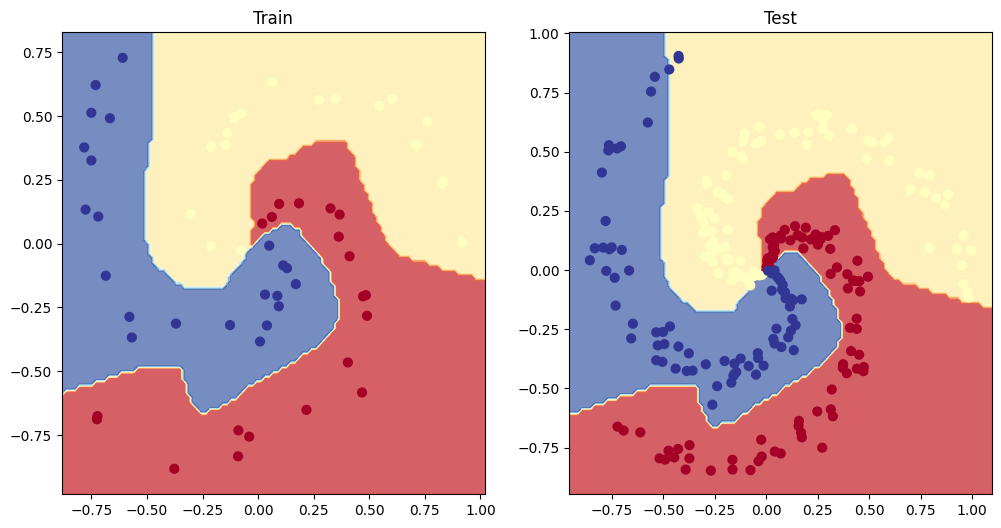

In [180]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)